## Problem Statement: I want to analyze and predict sales in the future. Also, I want to analyze the effect of markdowns, and see what actions are best to improve sales.

### Souce of Data: Kaggle

In [1]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, BayesianRidge
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

no display found. Using non-interactive Agg backend


## Explore Data

In [2]:
# download the dataset
features = pd.read_csv('/Users/marcmaestri/Downloads/archive-4/Features data set.csv')
sales = pd.read_csv('/Users/marcmaestri/Downloads/archive-4/sales data-set.csv')
stores = pd.read_csv('/Users/marcmaestri/Downloads/archive-4/stores data-set.csv')

In [3]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [5]:
stores.head(30)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


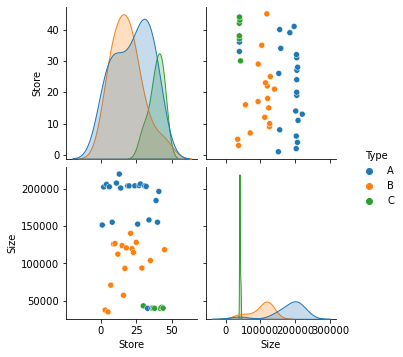

In [6]:
#lets look at the type vs size
sns.pairplot(data = stores, hue = 'Type')
plt.show()

In [7]:
### It seems the larger stores are type A, middle type B, and smaller type C, 
### But there are a few clear outliers
### I am going to analyze 1 store from each type

In [8]:
#fix datetime format to be consistant
features['Date'] = pd.to_datetime(features['Date'], infer_datetime_format=True)
sales['Date'] = pd.to_datetime(sales['Date'], infer_datetime_format=True)
#check datetime format
print(sales[0:1].Date, sales[-1:].Date)
print(features[0:1].Date, features[-1:].Date)

0   2010-05-02
Name: Date, dtype: datetime64[ns] 421569   2012-10-26
Name: Date, dtype: datetime64[ns]
0   2010-05-02
Name: Date, dtype: datetime64[ns] 8189   2013-07-26
Name: Date, dtype: datetime64[ns]


In [9]:
#merge df together into 1
df=pd.merge(sales,features, how='left')
df=pd.merge(df,stores, how='left')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [10]:
#fill NaN on markdowns with 0 to show no markdown
df=df.fillna(0)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-05-03,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


## Visualization
##### Variables over time

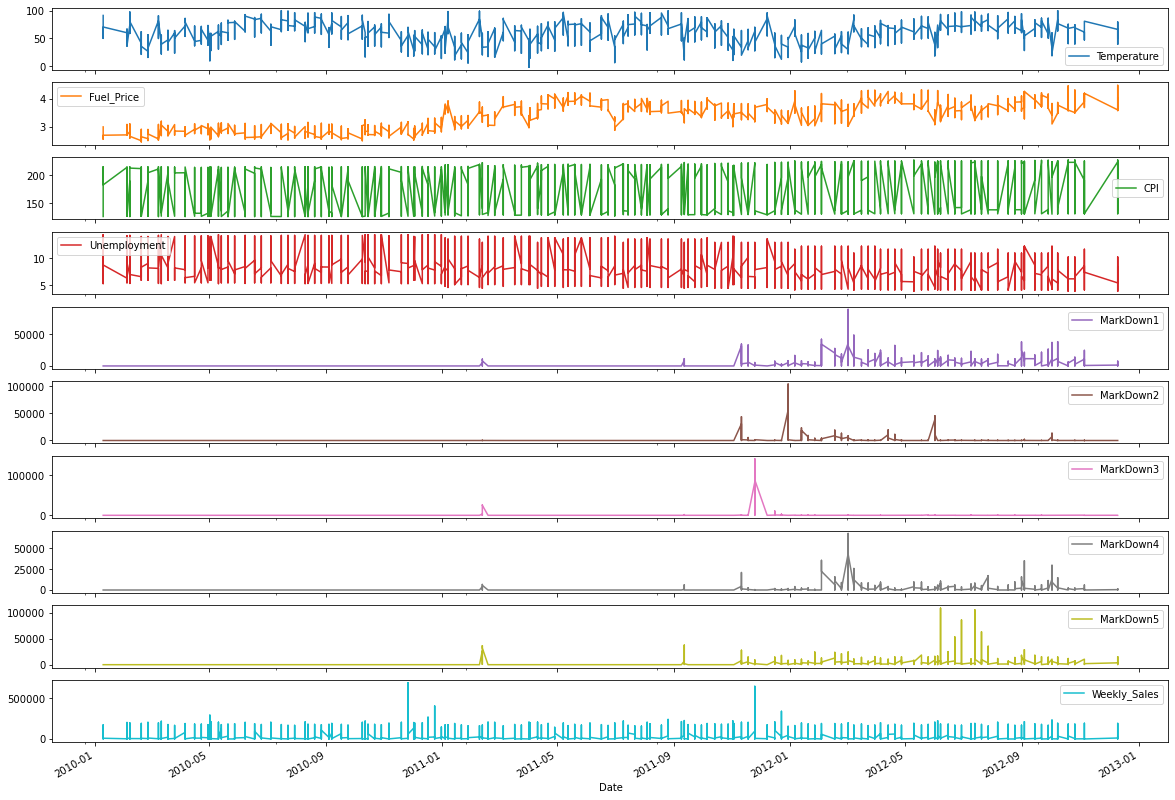

In [11]:
df[['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Weekly_Sales']].plot(x='Date', subplots=True, figsize=(20,15))
plt.show()

In [12]:
# we can see applying markdowns is a concept not used prior to 2011

In [13]:
# Lets drop markdowns for the sake of our predictor
df1=df.drop(columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

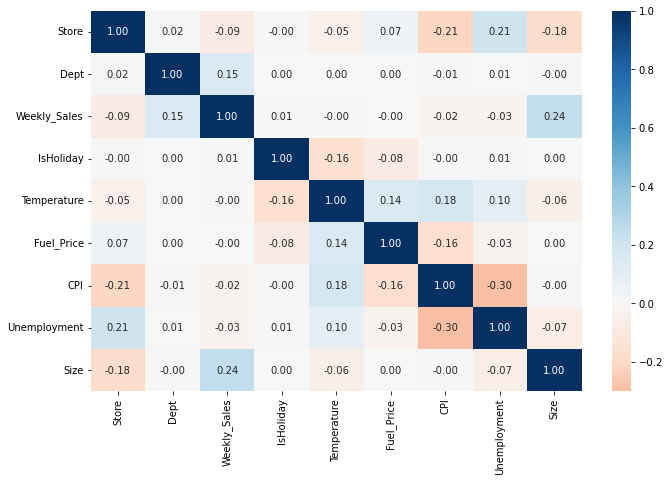

In [14]:
corr = df1.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", center=0, ax=ax)
plt.show()

In [15]:
# From the corr matrix, we see weekly sales does not have high correlation with anything in particular.
# Size has the highest correlation, makes sense because bigger stores had more sales.
df1.describe().T 

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
CPI,421570.0,171.201947,39.159276,126.064,132.022667,182.31878,212.416993,227.232807
Unemployment,421570.0,7.960289,1.863296,3.879,6.891000,7.86600,8.572000,14.313000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000


In [16]:
print(df1.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')


In [17]:
df1['Y'] = df['Date'].dt.year
df1['M'] = df['Date'].dt.month
df1['D'] = df['Date'].dt.dayofyear
df1['W'] = df['Date'].dt.weekofyear
df1.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Y,M,D,W
0,1,1,2010-05-02,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,2010,5,122,17
1,1,1,2010-12-02,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,2010,12,336,48
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,2010,2,50,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,2010,2,57,8
4,1,1,2010-05-03,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2010,5,123,18


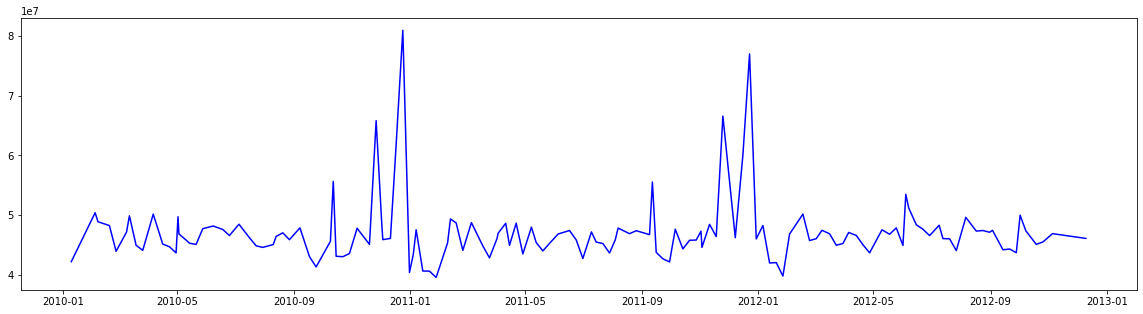

In [18]:
#lets look at total weekly sales over time
df_average_sales_weekly = df1.groupby('Date', as_index=False)\
    .agg({'Weekly_Sales': 'sum'})

df_average_sales_sorted = df_average_sales_weekly.sort_values('Weekly_Sales', ascending = False)

plt.figure(figsize=(20,5))

plt.plot(df_average_sales_weekly.Date, df_average_sales_weekly.Weekly_Sales, color = 'b')

plt.show()

In [19]:
### As assumed, there are jumps in sales during the holiday season

In [20]:
# lets pick one store in each type... a-24, b-25, c-30
dfa=df1.where(df['Store'] == 24)
dfa=dfa.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
dfa = dfa.set_index('Date')
dfa.head()

,Weekly_Sales
Date,
2010-01-10,1215273.20
2010-02-04,1478321.26
2010-02-07,1563387.94
2010-02-19,1385362.49
2010-02-26,1158722.74


In [21]:
dfb=df1.where(df['Store'] == 25)
dfb=dfb.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
dfb = dfb.set_index('Date')
dfb.head()

,Weekly_Sales
Date,
2010-01-10,658640.14
2010-02-04,822486.37
2010-02-07,759407.87
2010-02-19,676260.67
2010-02-26,628516.57


In [22]:
dfc=df1.where(df['Store'] == 30)
dfc=dfc.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
dfc = dfc.set_index('Date')
dfc.head()

,Weekly_Sales
Date,
2010-01-10,445475.30
2010-02-04,457884.06
2010-02-07,450337.47
2010-02-19,463513.26
2010-02-26,472330.71


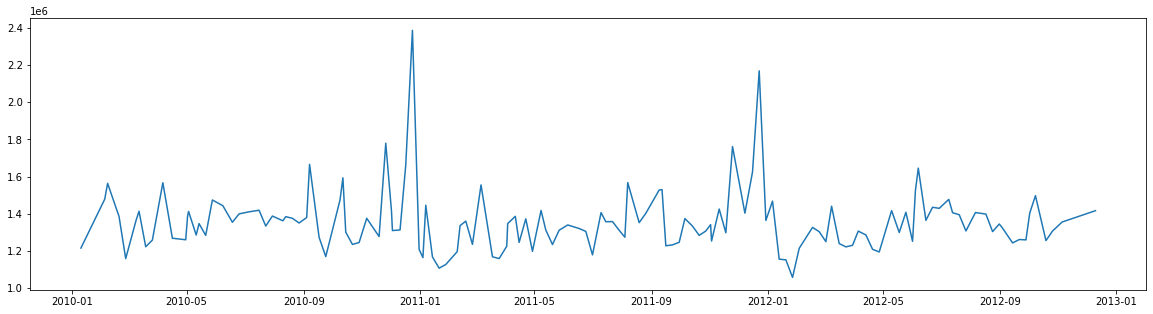

In [23]:
plt.figure(figsize=(20,5))
plt.plot(dfa.index, dfa.values)
plt.show()

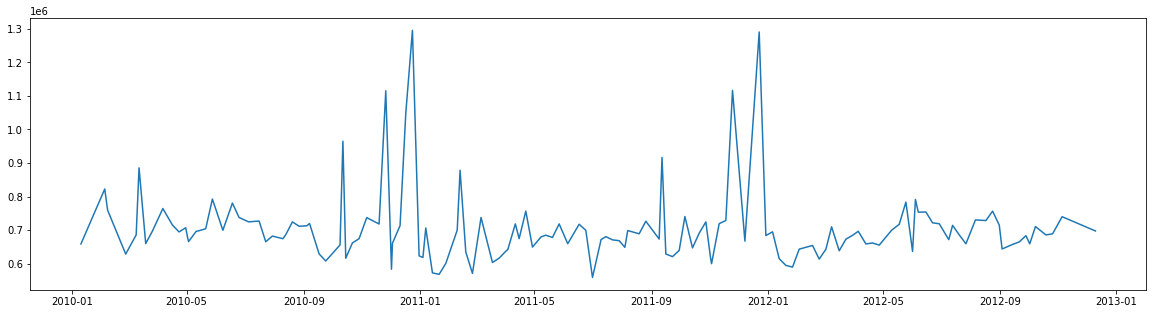

In [24]:
plt.figure(figsize=(20,5))
plt.plot(dfb.index, dfb.values)
plt.show()

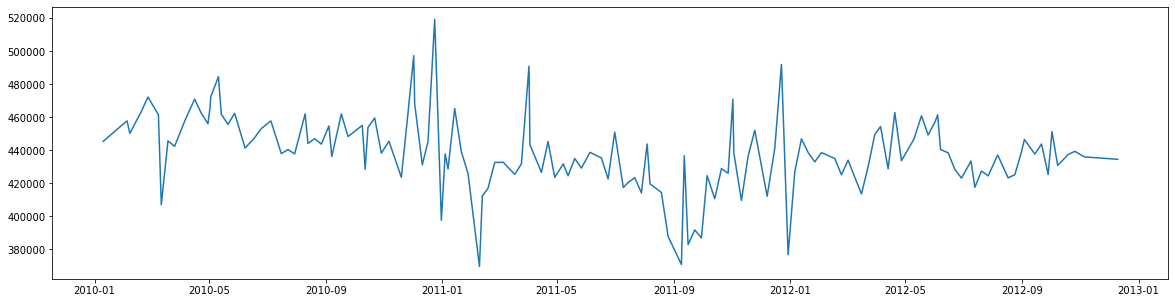

In [25]:
plt.figure(figsize=(20,5))
plt.plot(dfc.index, dfc.values)
plt.show()

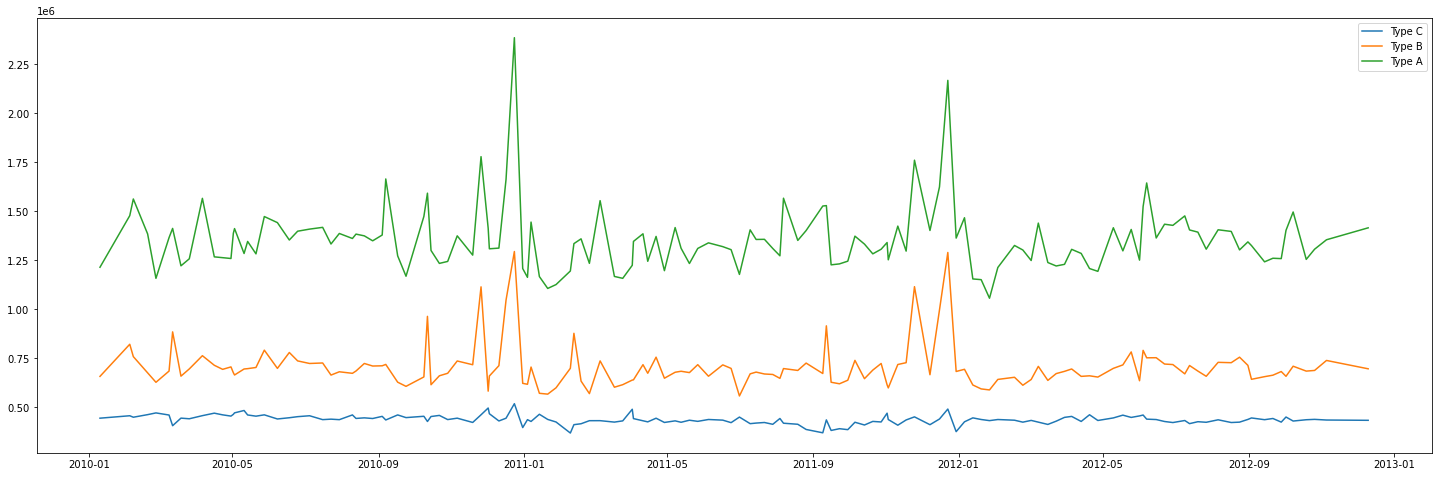

In [26]:
# similar trends for all 3 types, less spike on the smaller/lower volume stores (more 'stable')
fig, ax = plt.subplots(figsize=(25,8))
ax.plot(dfc.index, dfc.values, label = "Type C")
ax.plot(dfb.index, dfb.values, label = "Type B")
ax.plot(dfa.index, dfa.values, label = "Type A")
ax.legend()
plt.show()

In [27]:
# Lower volume store does not show holiday spike as much. Less 'one time' holiday shoppers? More rural stores?

In [28]:
## Modeling
### Use 3 different models with 5 variables

In [29]:
# Lets use the variables to predict weekly sales and see if our models are any good
predictors = ['IsHoliday', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment']
outcome = 'Weekly_Sales'

# Partition data into both train and test data
#
X = pd.get_dummies(df1[predictors], drop_first=True)
y = df1[outcome]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.40, random_state=33)

# Scale data for model
scaler = StandardScaler()
# Fit on training set only
scaler.fit(train_X)
# Apply transform to both the training set and the test set
scale_train_X = scaler.transform(train_X)
scale_test_X = scaler.transform(test_X)

In [30]:
# Use PCA to reduce the amount of components needed to run a test.
pcs = PCA()
pcs.fit(scale_train_X)
pcsSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
                              'Proportion of variance': pcs.explained_variance_ratio_,
                              'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary_df = pcsSummary_df.transpose()
pcsSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary_df.columns) + 1)]
pcsSummary_df.round(5)

,PC1,PC2,PC3,PC4,PC5
Standard deviation,1.15467,1.12374,0.99789,0.94427,0.71870
Proportion of variance,0.26665,0.25256,0.19916,0.17833,0.10331
Cumulative proportion,0.26665,0.51921,0.71837,0.89669,1.00000


In [31]:
# Build the linear regression model
#
retail_lm = LinearRegression()
retail_lm.fit(scale_train_X, train_y)
# Regression coefficients
#
print('intercept ', retail_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': retail_lm.coef_}))

# Accuracy Metrics for the Regression Model
#
# Performance measures
regressionSummary(train_y, retail_lm.predict(scale_train_X))

intercept  16021.754958686182
      Predictor  coefficient
0     IsHoliday   326.959629
1   Temperature   243.725792
2    Fuel_Price  -177.503664
3           CPI  -807.209467
4  Unemployment  -869.939026

Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 22771.6932
     Mean Absolute Error (MAE) : 15184.9546


In [32]:
# Use predict() to make predictions on a new set
retail_lm_pred = retail_lm.predict(scale_test_X)

result = pd.DataFrame({'Predicted': retail_lm_pred, 'Actual': test_y, 'Residual': test_y - retail_lm_pred})
print(result.head(10))

# Accuracy measures
regressionSummary(test_y, retail_lm_pred)

           Predicted    Actual      Residual
217099  18064.434373  68505.67  50441.235627
32767   18676.434800   9840.25  -8836.184800
28430   15432.329947   1768.81 -13663.519947
155667  15815.887232      4.86 -15811.027232
287365  15314.245387     57.52 -15256.725387
356856  14543.096713     74.19 -14468.906713
98957   15524.843852  38814.82  23289.976148
315859  16654.913712    865.71 -15789.203712
390748  16090.954654  20111.17   4020.215346
90527   16571.172999  62048.07  45476.897001

Regression statistics

               Mean Error (ME) : -99.6517
Root Mean Squared Error (RMSE) : 22566.3262
     Mean Absolute Error (MAE) : 15117.7306


In [33]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
retail_R = Ridge()

#fit model
retail_R.fit(X, y)


print('intercept ', retail_R.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': retail_R.coef_}))

# Accuracy Metrics for the Regression Model
#
# Performance measures
regressionSummary(train_y, retail_R.predict(scale_train_X))

intercept  23582.01546811033
      Predictor  coefficient
0     IsHoliday  1264.585107
1   Temperature    13.774454
2    Fuel_Price  -383.925008
3           CPI   -20.655180
4  Unemployment  -463.657822

Regression statistics

               Mean Error (ME) : -7560.2605
Root Mean Squared Error (RMSE) : 24028.4223
     Mean Absolute Error (MAE) : 18871.9060


In [34]:
# Use predict() to make predictions on a new set
retail_R_pred = retail_R.predict(scale_test_X)

result = pd.DataFrame({'Predicted': retail_R_pred, 'Actual': test_y, 'Residual': test_y - retail_R_pred})
print(result.head(10))

# Accuracy measures
regressionSummary(test_y, retail_R_pred)

           Predicted    Actual      Residual
217099  23612.207227  68505.67  44893.462773
32767   24115.986954   9840.25 -14275.736954
28430   24007.569549   1768.81 -22238.759549
155667  23295.987176      4.86 -23291.127176
287365  23035.845492     57.52 -22978.325492
356856  21911.132501     74.19 -21836.942501
98957   23216.553589  38814.82  15598.266411
315859  22584.330469    865.71 -21718.620469
390748  23925.614150  20111.17  -3814.444150
90527   23197.449064  62048.07  38850.620936

Regression statistics

               Mean Error (ME) : -7658.1992
Root Mean Squared Error (RMSE) : 23865.4706
     Mean Absolute Error (MAE) : 18817.5555


In [35]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
retail_L = LassoCV()

#fit model
retail_L.fit(X, y)

print('intercept ', retail_L.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': retail_L.coef_}))

# Accuracy Metrics for the Regression Model
#
# Performance measures
regressionSummary(train_y, retail_L.predict(scale_train_X))

intercept  15981.258123467045
      Predictor   coefficient
0     IsHoliday  0.000000e+00
1   Temperature -0.000000e+00
2    Fuel_Price -0.000000e+00
3           CPI -3.098000e-14
4  Unemployment -0.000000e+00

Regression statistics

               Mean Error (ME) : 40.4968
Root Mean Squared Error (RMSE) : 22793.2573
     Mean Absolute Error (MAE) : 15187.9542


In [36]:
# Use predict() to make predictions on a new set
retail_L_pred = retail_L.predict(scale_test_X)

result = pd.DataFrame({'Predicted': retail_L_pred, 'Actual': test_y, 'Residual': test_y - retail_L_pred})
print(result.head(10))

# Accuracy measures
regressionSummary(test_y, retail_L_pred)

           Predicted    Actual      Residual
217099  15981.258123  68505.67  52524.411877
32767   15981.258123   9840.25  -6141.008123
28430   15981.258123   1768.81 -14212.448123
155667  15981.258123      4.86 -15976.398123
287365  15981.258123     57.52 -15923.738123
356856  15981.258123     74.19 -15907.068123
98957   15981.258123  38814.82  22833.561877
315859  15981.258123    865.71 -15115.548123
390748  15981.258123  20111.17   4129.911877
90527   15981.258123  62048.07  46066.811877

Regression statistics

               Mean Error (ME) : -60.7453
Root Mean Squared Error (RMSE) : 22587.4459
     Mean Absolute Error (MAE) : 15121.6777


## Markdown (Discount) Analysis
#### I want to analyze the markdowns and look for significance over time and store type

Text(0.5, 0, 'Date')

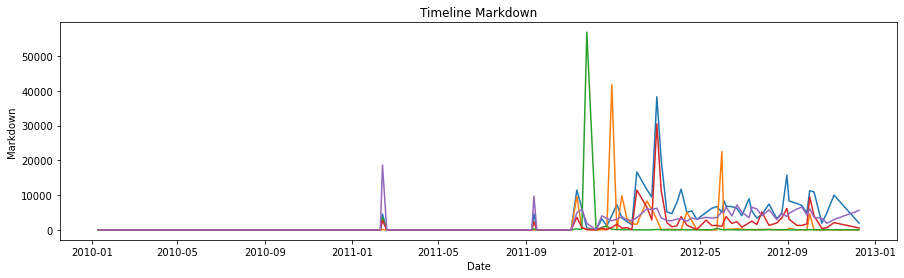

In [37]:
plt.figure(figsize=(15,4))
train_markdown = df[df.MarkDown2.notnull()]
train_markdown = train_markdown.groupby("Date").agg({"MarkDown1":"mean","MarkDown2":"mean","MarkDown3":"mean","MarkDown4":"mean","MarkDown5":"mean"})


plt.plot(train_markdown.index,train_markdown.MarkDown1)
plt.plot(train_markdown.index,train_markdown.MarkDown2)
plt.plot(train_markdown.index,train_markdown.MarkDown3)
plt.plot(train_markdown.index,train_markdown.MarkDown4)
plt.plot(train_markdown.index,train_markdown.MarkDown5)
plt.title("Timeline Markdown")
plt.ylabel("Markdown")
plt.xlabel("Date")

Text(0, 0.5, 'Markdown')

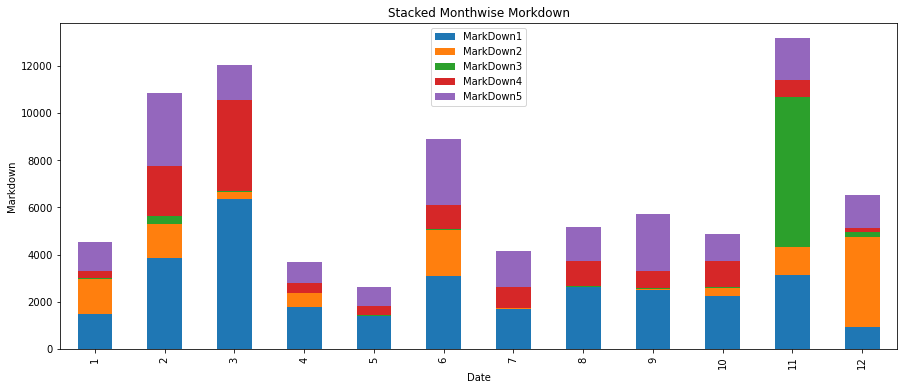

In [38]:
train_markdown_month = train_markdown.groupby(train_markdown.index.month).agg({"MarkDown1":"mean","MarkDown2":"mean","MarkDown3":"mean","MarkDown4":"mean","MarkDown5":"mean"})

train_markdown_month.plot(kind='bar', stacked=True,figsize=(15,6))
plt.title("Stacked Monthwise Morkdown")
plt.ylabel("Markdown")

Text(0, 0.5, 'Markdown')

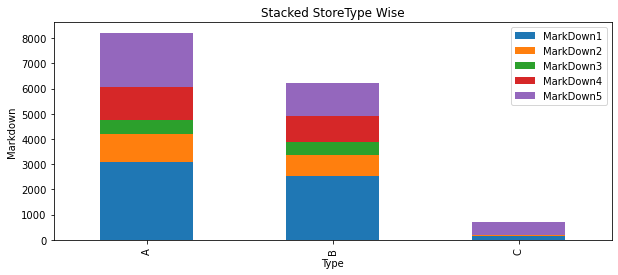

In [39]:
train_markdown_1 = df[df.MarkDown2.notnull()]
train_markdown_type = train_markdown_1.groupby("Type").agg({"MarkDown1":"mean","MarkDown2":"mean","MarkDown3":"mean","MarkDown4":"mean","MarkDown5":"mean"})

train_markdown_type.plot(kind='bar', stacked=True,figsize=(10,4))
plt.title("Stacked StoreType Wise")
plt.ylabel("Markdown")

# Findings
### Sales can be expected to stay seasonal. My predictive models are off by about 22k for weekly sales, which is not very accurate at all. But I do see opportunity for type C stores to possibly add more markdown2 and markdown3 during the holiday season to possibly see a greater spike in sales similar to type A/B during the holiday season.